In [19]:
from ctypes import *
import time
from sys import path
import sys
from os import sep

if sys.platform.startswith("win"):
    dwf = cdll.dwf
    constants_path = "C:" + sep + "Program Files (x86)" + sep + "Digilent" + sep + "WaveFormsSDK" + sep + "samples" + sep + "py"
elif sys.platform.startswith("darwin"):
    dwf = cdll.LoadLibrary("/Library/Frameworks/dwf.framework/dwf")
    constants_path = "/Applications/WaveForms.app/Contents/Resources/SDK/samples/py"
else:
    dwf = cdll.LoadLibrary("libdwf.so")
    constants_path = "/usr/share/digilent/waveforms/samples/py"

path.append(constants_path)
import dwfconstants as constants

In [20]:
dwf.FDwfDeviceCloseAll()
filter_flags = c_int(constants.enumfilterType.value | constants.enumfilterUSB.value)
device_count = c_int()
dwf.FDwfEnum(filter_flags, byref(device_count))

hdwf = c_int()
dwf.FDwfDeviceOpen(c_int(-1), byref(hdwf))
if hdwf.value == 0:
    raise RuntimeError("Failed to open device.")
print(hdwf.value)

dwf.FDwfAnalogIOReset(hdwf)
dwf.FDwfAnalogIOChannelNodeSet(hdwf, c_int(0), c_int(1), c_double(3.0))
dwf.FDwfAnalogIOChannelNodeSet(hdwf, c_int(0), c_int(0), c_double(1))
dwf.FDwfAnalogIOEnableSet(hdwf, c_int(1))
time.sleep(0.5)

vpos = c_double()
dwf.FDwfAnalogIOStatus(hdwf)
dwf.FDwfAnalogIOChannelNodeStatus(hdwf, c_int(0), c_int(1), byref(vpos))
print(f"Power: +{vpos.value:.2f}V")

1
Power: +3.01V


In [21]:
DEVICE_ADDR = 0x52
ENABLE_REG = 0x80
ATIME_REG = 0x81
CONTROL_REG = 0x8F
CDATAL_REG = 0x94
CDATAH_REG = 0x95
RDATAL_REG = 0x96
RDATAH_REG = 0x97
GDATAL_REG = 0x98
GDATAH_REG = 0x99
BDATAL_REG = 0x9A
BDATAH_REG = 0x9B

def write_register(reg, value):
    iNak = c_int()
    rgTX = (c_ubyte * 2)(reg, value)
    dwf.FDwfDigitalI2cWrite(hdwf, c_int(DEVICE_ADDR), rgTX, c_int(2), byref(iNak))
    return iNak.value == 0

def read_register(reg):
    iNak = c_int()
    rgTX = (c_ubyte * 1)(reg)
    dwf.FDwfDigitalI2cWrite(hdwf, c_int(DEVICE_ADDR), rgTX, c_int(1), byref(iNak))
    if iNak.value == 0:
        rgRX = (c_ubyte * 1)()
        dwf.FDwfDigitalI2cRead(hdwf, c_int(DEVICE_ADDR), rgRX, c_int(1), byref(iNak))
        if iNak.value == 0:
            return rgRX[0]
    return None

dwf.FDwfDigitalI2cRateSet(hdwf, c_double(100e3))
dwf.FDwfDigitalI2cSclSet(hdwf, c_int(0))
dwf.FDwfDigitalI2cSdaSet(hdwf, c_int(1))
iNak = c_int()
dwf.FDwfDigitalI2cClear(hdwf, byref(iNak))

1

In [22]:
write_register(ENABLE_REG, 0x01)
time.sleep(0.01)
write_register(ENABLE_REG, 0x03)
write_register(ATIME_REG, 0xFF)
write_register(CONTROL_REG, 0x02)

def read_colors():
    time.sleep(0.1)
    
    clear_low = read_register(CDATAL_REG)
    clear_high = read_register(CDATAH_REG)
    red_low = read_register(RDATAL_REG)
    red_high = read_register(RDATAH_REG)
    green_low = read_register(GDATAL_REG)
    green_high = read_register(GDATAH_REG)
    blue_low = read_register(BDATAL_REG)
    blue_high = read_register(BDATAH_REG)
    
    if all(val is not None for val in [clear_low, clear_high, red_low, red_high, green_low, green_high, blue_low, blue_high]):
        clear = (clear_high << 8) | clear_low
        red = (red_high << 8) | red_low
        green = (green_high << 8) | green_low
        blue = (blue_high << 8) | blue_low
        return {'clear': clear, 'red': red, 'green': green, 'blue': blue}
    return None

In [23]:

# write_register(CONTROL_REG,0)
data={'clear': [], 'red': [], 'green': [], 'blue': []}
for i in range(256):
    write_register(ATIME_REG,255-i)
    colors = read_colors()
    data['clear'].append(colors['clear'])
    data['red'].append(colors['red'])
    data['green'].append(colors['green'])
    data['blue'].append(colors['blue'])
    print(f"A_TIME {255-i}: {colors['clear']}, R: {colors['red']}, G: {colors['green']}, B: {colors['blue']}")

A_TIME 255: 86, R: 21, G: 34, B: 29
A_TIME 254: 158, R: 35, G: 83, B: 62
A_TIME 253: 294, R: 66, G: 111, B: 97
A_TIME 252: 359, R: 81, G: 133, B: 117
A_TIME 251: 453, R: 99, G: 163, B: 142
A_TIME 250: 529, R: 119, G: 196, B: 171
A_TIME 249: 589, R: 133, G: 222, B: 193
A_TIME 248: 690, R: 156, G: 255, B: 224
A_TIME 247: 792, R: 179, G: 293, B: 246
A_TIME 246: 838, R: 190, G: 310, B: 270
A_TIME 245: 984, R: 222, G: 365, B: 314
A_TIME 244: 1045, R: 236, G: 387, B: 335
A_TIME 243: 1098, R: 248, G: 406, B: 354
A_TIME 242: 1241, R: 280, G: 459, B: 389
A_TIME 241: 1315, R: 301, G: 494, B: 430
A_TIME 240: 1399, R: 316, G: 517, B: 450
A_TIME 239: 1490, R: 336, G: 542, B: 472
A_TIME 238: 1565, R: 353, G: 579, B: 505
A_TIME 237: 1609, R: 363, G: 595, B: 519
A_TIME 236: 1731, R: 391, G: 641, B: 558
A_TIME 235: 1838, R: 415, G: 672, B: 585
A_TIME 234: 1906, R: 430, G: 705, B: 615
A_TIME 233: 1976, R: 446, G: 732, B: 638
A_TIME 232: 2077, R: 468, G: 769, B: 670
A_TIME 231: 2151, R: 487, G: 796, B: 6

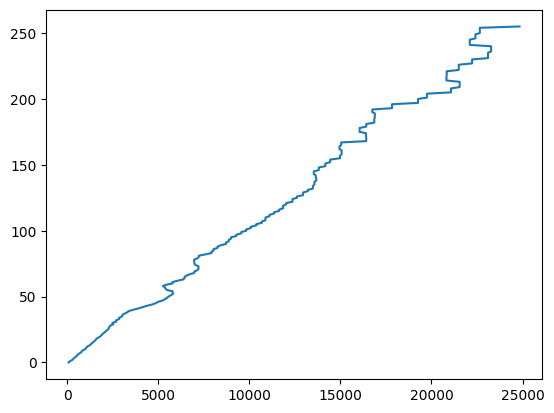

In [24]:
# print(arr)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df = pd.DataFrame(data)
#sns.histplot(data=df,x="clear", bins=30)
plt.plot(df["clear"], df.index)

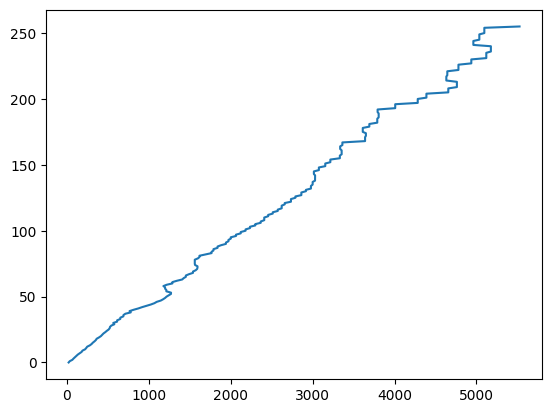

In [26]:
plt.plot(df["red"], df.index)

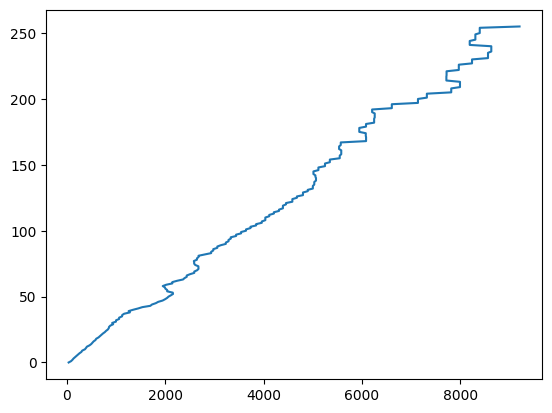

In [27]:
plt.plot(df["green"], df.index)

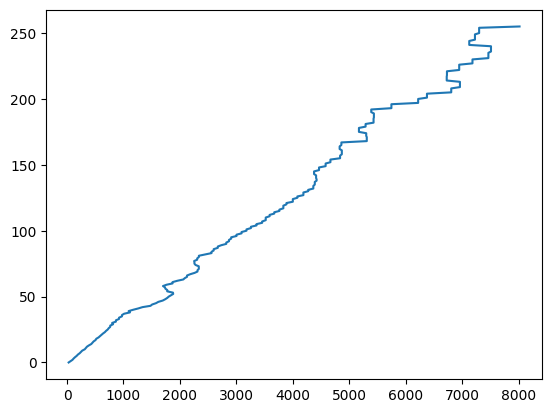

In [28]:
plt.plot(df["blue"], df.index)

In [29]:
def cleanup():
    dwf.FDwfDeviceClose(hdwf)
cleanup()